In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
import sys
plt.style.use("~/evanstyle.mplstyle")

sys.path.append("../CombinedData/")
import Dataset

In [2]:
topdir = "../../data/Run8/"
datasets = ["timing-tester/"]

ds_single = "timing-tester/"
config = "../configs/run8_config.yaml"

In [4]:
#load the dataset object for the single file selected
ds = Dataset.Dataset(topdir+ds_single, config)

no ramp file present at ../../data/Run8/timing-tester/ramp.txt, leaving it empty
no g-events-file present at ../../data/Run8/timing-tester/g_events.txt, leaving it empty
No ramp data in this dataset


In [6]:
#some example plotting
ex_ad2 = pickle.load(open(ds.ad2_files[0], "rb"))[0]
ex_str = pickle.load(open(ds.struck_files[0], "rb"))[0]

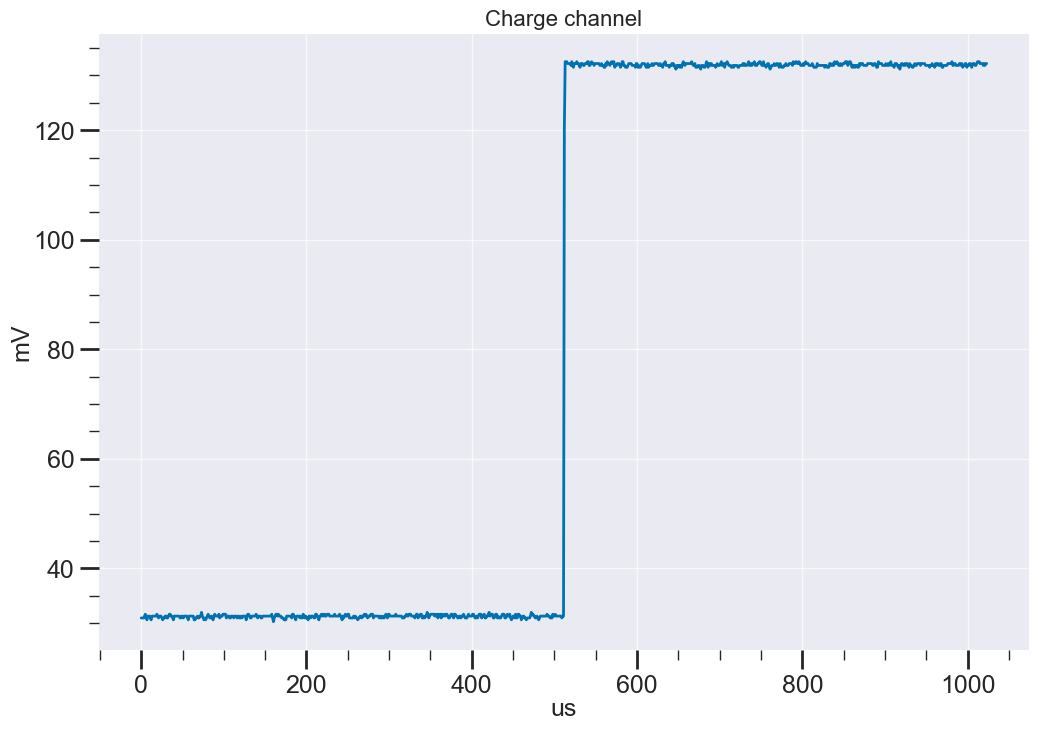

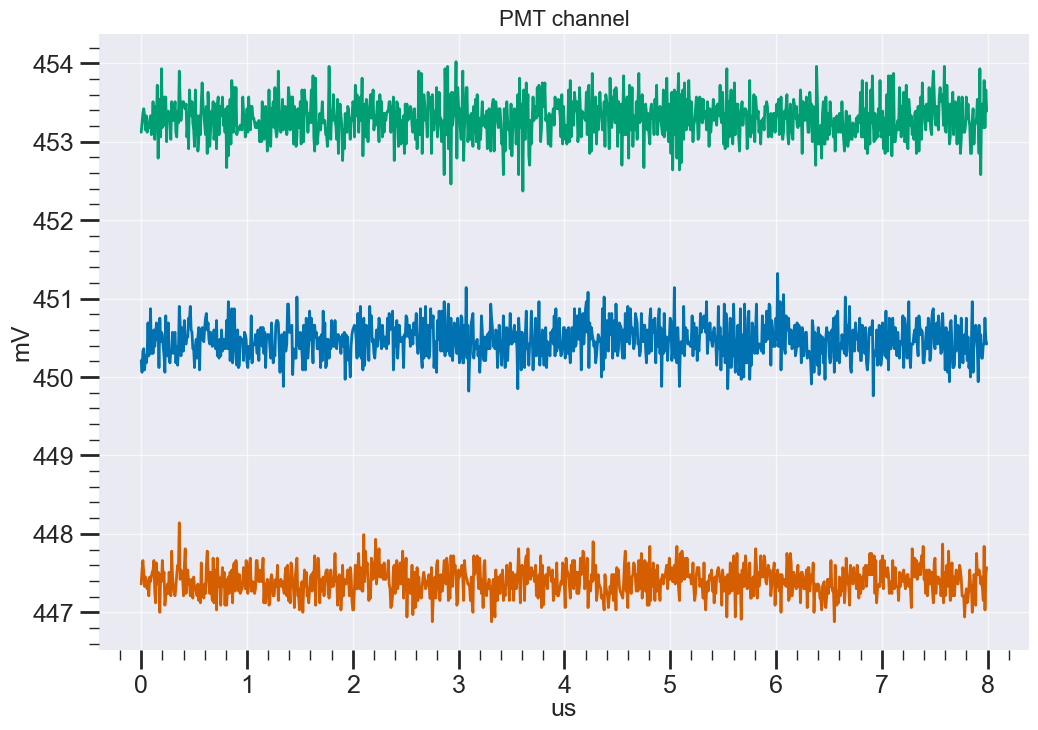

In [20]:
row = ex_ad2.iloc[0]
fig, ax = plt.subplots()

times = np.arange(0, len(row["Data"][0])*row["dT"]*1e6, row["dT"]*1e6) #times in microseconds
ax.plot(times, row["Data"][1])
ax.set_ylabel("mV")
ax.set_xlabel("us")
ax.set_title("Charge channel")
plt.show()

row = ex_str.iloc[470]
fig, ax = plt.subplots()

dT = 1/float(ds.config["struck_reduction"]["clock"])
times = np.arange(0, (len(row["Data"][0]) - 1)*dT*1e6, dT*1e6) #times in microseconds
ax.plot(times, row["Data"][0])
ax.plot(times, row["Data"][1])
ax.plot(times, row["Data"][2])
ax.set_ylabel("mV")
ax.set_xlabel("us")
ax.set_title("PMT channel")
plt.show()

In [11]:
ex_str

,Seconds,Nanoseconds,Data
0,1.695924e+09,7.499173e+08,"[[450.45, 450.65999999999997, 450.419999999999..."
1,1.695924e+09,9.468473e+08,"[[450.45, 450.41999999999996, 450.45, 450.45, ..."
2,1.695924e+09,1.490366e+08,"[[450.69, 450.57, 450.78, 450.57, 450.39, 450...."
3,1.695924e+09,3.505465e+08,"[[450.69, 450.75, 449.84999999999997, 450.3599..."
4,1.695924e+09,5.480573e+08,"[[450.69, 450.24, 450.71999999999997, 450.51, ..."
...,...,...,...
494,1.695924e+09,5.595136e+08,"[[450.9, 450.63, 450.45, 450.39, 450.21, 451.1..."
495,1.695924e+09,7.490145e+08,"[[450.69, 450.75, 450.84, 450.41999999999996, ..."
496,1.695924e+09,9.517492e+08,"[[450.03, 450.69, 450.21, 450.53999999999996, ..."
497,1.695924e+09,1.553951e+08,"[[450.75, 450.57, 450.78, 450.81, 450.53999999..."
